## EPOCH (200) BATCH SIZE (100) 

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

In [2]:
from PIL import Image
import glob
image_list = []

for filepath in glob.glob('trafficsigns_dataset/*/*/*.png', recursive=True): 
    filename = filepath.split("\\")[-1]
    shape = filepath.split("\\")[-3]
    image_list.append((filepath, shape))
        
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'shape'])

#Convert shape labels to integers
d = {'diamond':0,'hex':1,'round':2,'square':3, 'triangle':4}
data['shape_num'] = data['shape'].map(d, na_action='ignore')

In [3]:
#Generate train/test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras import regularizers, optimizers

input_ = Input(shape=(28,28,3))
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None))(input_)
x=Flatten()(input_slice)

h=Dense(64)(x)
h=Activation('sigmoid')(h)

out_=Dense(5)(h)
out_ =Activation('softmax')(out_)

model = Model(inputs=input_, outputs=out_)

In [5]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0     

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255,data_format='channels_last')

batch_size= 100

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28,28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=test,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28,28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [8]:
def calculate_losses(model_, data_generator_, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            break
        return np.mean(loss_hold), np.mean(acc_hold)

In [9]:
def train_model(model_, train_generator_in, validation_generator_in, num_epoch=200, verbose=False):
    res = []
    for e in range(num_epoch): 
        print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []
        # iterate over each batch
        for x,y in train_generator_in:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc perbatch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= train.shape[0] / batch_size:
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)
        print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))

        loss, acc = calculate_losses(model_, validation_generator_in, test.shape[0], batch_size)
        print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [10]:
res = train_model(model, train_generator, validation_generator, num_epoch=200, verbose=False)

Epoch 0
Training epoch 0: Loss = 1.245889631907145, Accuracy = 0.4841073433558146
Validation epoch 0: Loss = 1.1513453722000122, Accuracy = 0.5400000214576721
Epoch 1
Training epoch 1: Loss = 1.123530348141988, Accuracy = 0.5323841810226441
Validation epoch 1: Loss = 0.9869446754455566, Accuracy = 0.6000000238418579
Epoch 2
Training epoch 2: Loss = 1.0193810005982717, Accuracy = 0.6021723161141078
Validation epoch 2: Loss = 0.9311596751213074, Accuracy = 0.7099999785423279
Epoch 3
Training epoch 3: Loss = 0.9255866825580596, Accuracy = 0.6902005712191264
Validation epoch 3: Loss = 0.921997606754303, Accuracy = 0.7099999785423279
Epoch 4
Training epoch 4: Loss = 0.8408431390921275, Accuracy = 0.7276186386744181
Validation epoch 4: Loss = 0.8516996502876282, Accuracy = 0.7300000190734863
Epoch 5
Training epoch 5: Loss = 0.7690848767757416, Accuracy = 0.7638305048147838
Validation epoch 5: Loss = 0.7694313526153564, Accuracy = 0.7599999904632568
Epoch 6
Training epoch 6: Loss = 0.70642454

Training epoch 51: Loss = 0.1830317422747612, Accuracy = 0.9520367324352265
Validation epoch 51: Loss = 0.14475396275520325, Accuracy = 0.9700000286102295
Epoch 52
Training epoch 52: Loss = 0.17626437942186993, Accuracy = 0.9570367296536764
Validation epoch 52: Loss = 0.21285225450992584, Accuracy = 0.9399999976158142
Epoch 53
Training epoch 53: Loss = 0.17682289704680443, Accuracy = 0.9559067885080973
Validation epoch 53: Loss = 0.17400355637073517, Accuracy = 0.9599999785423279
Epoch 54
Training epoch 54: Loss = 0.17396018852790196, Accuracy = 0.956703394651413
Validation epoch 54: Loss = 0.2047492414712906, Accuracy = 0.949999988079071
Epoch 55
Training epoch 55: Loss = 0.17114352186520895, Accuracy = 0.958036728700002
Validation epoch 55: Loss = 0.18554359674453735, Accuracy = 0.9750000238418579
Epoch 56
Training epoch 56: Loss = 0.16945934693018597, Accuracy = 0.9580193758010864
Validation epoch 56: Loss = 0.2389649897813797, Accuracy = 0.9399999976158142
Epoch 57
Training epoch 5

Training epoch 101: Loss = 0.10258071348071099, Accuracy = 0.9797034005324046
Validation epoch 101: Loss = 0.18755458295345306, Accuracy = 0.949999988079071
Epoch 102
Training epoch 102: Loss = 0.10287053311864534, Accuracy = 0.9797683715820312
Validation epoch 102: Loss = 0.15325094759464264, Accuracy = 0.9399999976158142
Epoch 103
Training epoch 103: Loss = 0.10181441120803356, Accuracy = 0.9791384279727936
Validation epoch 103: Loss = 0.1463661938905716, Accuracy = 0.949999988079071
Epoch 104
Training epoch 104: Loss = 0.1008839135368665, Accuracy = 0.9800064663092295
Validation epoch 104: Loss = 0.14071017503738403, Accuracy = 0.9399999976158142
Epoch 105
Training epoch 105: Loss = 0.09891979346672694, Accuracy = 0.9797034005324046
Validation epoch 105: Loss = 0.11418315768241882, Accuracy = 0.9700000286102295
Epoch 106
Training epoch 106: Loss = 0.09908516655365626, Accuracy = 0.9801017085711161
Validation epoch 106: Loss = 0.2095392644405365, Accuracy = 0.9399999976158142
Epoch 1

Training epoch 151: Loss = 0.06688079883654913, Accuracy = 0.9887683709462484
Validation epoch 151: Loss = 0.0674329400062561, Accuracy = 1.0
Epoch 152
Training epoch 152: Loss = 0.06789245096345743, Accuracy = 0.9884350339571635
Validation epoch 152: Loss = 0.07624799013137817, Accuracy = 0.9800000190734863
Epoch 153
Training epoch 153: Loss = 0.066777492997547, Accuracy = 0.9884350379308064
Validation epoch 153: Loss = 0.08773569762706757, Accuracy = 0.9700000286102295
Epoch 154
Training epoch 154: Loss = 0.06523682760695616, Accuracy = 0.9890000065167744
Validation epoch 154: Loss = 0.046694234013557434, Accuracy = 0.9900000095367432
Epoch 155
Training epoch 155: Loss = 0.06571923221151034, Accuracy = 0.9885000069936116
Validation epoch 155: Loss = 0.16187399625778198, Accuracy = 0.949999988079071
Epoch 156
Training epoch 156: Loss = 0.06578919937213262, Accuracy = 0.9883333444595337
Validation epoch 156: Loss = 0.0697290226817131, Accuracy = 0.9800000190734863
Epoch 157
Training ep

In [11]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

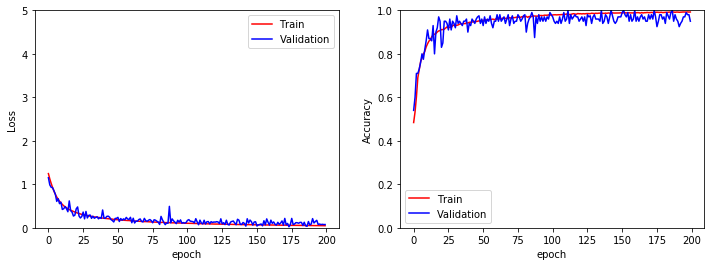

In [12]:
plot_results(res)

## DROPOUT

In [14]:
from tensorflow.keras.metrics import categorical_accuracy

input_ = Input(shape=(28, 28, 3))
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice) 

# Hidden layer
h = Dense(64)(x) 
h = Activation('sigmoid')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(5)(h) 
out_ = Activation('softmax')(out_)

# Define model
model_drop = Model(inputs=input_, outputs=out_)

model_drop.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])


model_drop.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325 

In [15]:
res = train_model(model_drop, train_generator, validation_generator, num_epoch=200, verbose=False)

Epoch 0
Training epoch 0: Loss = 1.3719398299853007, Accuracy = 0.4379773984352748
Validation epoch 0: Loss = 1.2221652269363403, Accuracy = 0.44999998807907104
Epoch 1
Training epoch 1: Loss = 1.215960677464803, Accuracy = 0.5046892652908961
Validation epoch 1: Loss = 1.1131560802459717, Accuracy = 0.5199999809265137
Epoch 2
Training epoch 2: Loss = 1.1449400424957275, Accuracy = 0.5434406737486521
Validation epoch 2: Loss = 1.1586637496948242, Accuracy = 0.4699999988079071
Epoch 3
Training epoch 3: Loss = 1.0903943300247192, Accuracy = 0.5760056455930074
Validation epoch 3: Loss = 0.950005054473877, Accuracy = 0.6000000238418579
Epoch 4
Training epoch 4: Loss = 1.0285766124725342, Accuracy = 0.5969971736272176
Validation epoch 4: Loss = 0.8564862608909607, Accuracy = 0.7300000190734863
Epoch 5
Training epoch 5: Loss = 0.9840294857819875, Accuracy = 0.6367740094661712
Validation epoch 5: Loss = 0.973339855670929, Accuracy = 0.5899999737739563
Epoch 6
Training epoch 6: Loss = 0.9469531

Training epoch 51: Loss = 0.37357058624426526, Accuracy = 0.8720819195111592
Validation epoch 51: Loss = 0.2848139703273773, Accuracy = 0.8999999761581421
Epoch 52
Training epoch 52: Loss = 0.38114319294691085, Accuracy = 0.8665536761283874
Validation epoch 52: Loss = 0.31422802805900574, Accuracy = 0.8999999761581421
Epoch 53
Training epoch 53: Loss = 0.3898252179225286, Accuracy = 0.8714802245299021
Validation epoch 53: Loss = 0.1715080291032791, Accuracy = 0.9800000190734863
Epoch 54
Training epoch 54: Loss = 0.364997531970342, Accuracy = 0.877785309155782
Validation epoch 54: Loss = 0.24839743971824646, Accuracy = 0.949999988079071
Epoch 55
Training epoch 55: Loss = 0.3635921498139699, Accuracy = 0.878906786441803
Validation epoch 55: Loss = 0.2635408639907837, Accuracy = 0.949999988079071
Epoch 56
Training epoch 56: Loss = 0.3620556866129239, Accuracy = 0.8706513285636902
Validation epoch 56: Loss = 0.23356571793556213, Accuracy = 0.9300000071525574
Epoch 57
Training epoch 57: Los

Training epoch 102: Loss = 0.2590081582466761, Accuracy = 0.9112485925356547
Validation epoch 102: Loss = 0.18894705176353455, Accuracy = 0.949999988079071
Epoch 103
Training epoch 103: Loss = 0.26573091795047127, Accuracy = 0.908573446671168
Validation epoch 103: Loss = 0.300834983587265, Accuracy = 0.8999999761581421
Epoch 104
Training epoch 104: Loss = 0.257620374361674, Accuracy = 0.9130193730195363
Validation epoch 104: Loss = 0.12828846275806427, Accuracy = 0.9800000190734863
Epoch 105
Training epoch 105: Loss = 0.2451659659544627, Accuracy = 0.9219067831834157
Validation epoch 105: Loss = 0.1710858792066574, Accuracy = 0.9399999976158142
Epoch 106
Training epoch 106: Loss = 0.2566666449109713, Accuracy = 0.9153700590133667
Validation epoch 106: Loss = 0.22284503281116486, Accuracy = 0.949999988079071
Epoch 107
Training epoch 107: Loss = 0.25737631221612295, Accuracy = 0.9125734488169353
Validation epoch 107: Loss = 0.18492776155471802, Accuracy = 0.9399999976158142
Epoch 108
Tra

Training epoch 152: Loss = 0.20398577203353246, Accuracy = 0.9300605316956838
Validation epoch 152: Loss = 0.14697957038879395, Accuracy = 0.9700000286102295
Epoch 153
Training epoch 153: Loss = 0.2024048537015915, Accuracy = 0.9316101690133413
Validation epoch 153: Loss = 0.07050871104001999, Accuracy = 0.9800000190734863
Epoch 154
Training epoch 154: Loss = 0.18963138510783514, Accuracy = 0.9398050804932913
Validation epoch 154: Loss = 0.2702246606349945, Accuracy = 0.9200000166893005
Epoch 155
Training epoch 155: Loss = 0.19651831686496735, Accuracy = 0.9347118655840556
Validation epoch 155: Loss = 0.13618551194667816, Accuracy = 0.9700000286102295
Epoch 156
Training epoch 156: Loss = 0.19535052441060544, Accuracy = 0.9331016937891642
Validation epoch 156: Loss = 0.19472147524356842, Accuracy = 0.9300000071525574
Epoch 157
Training epoch 157: Loss = 0.20459989781181018, Accuracy = 0.9368785341580709
Validation epoch 157: Loss = 0.14961814880371094, Accuracy = 0.9599999785423279
Epoc

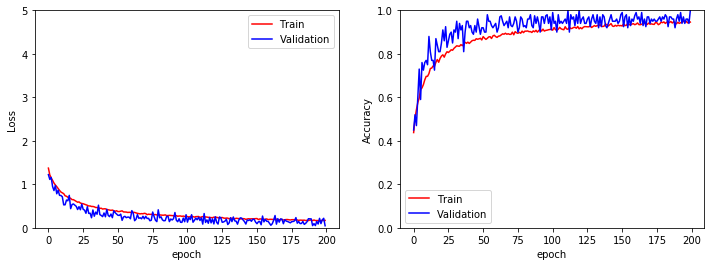

In [16]:
plot_results(res)

## CNN + Augmentation

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 100

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=test,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          1

In [19]:
res = train_model(model_cnn, train_generator, validation_generator, num_epoch=200, verbose=False)

Epoch 0
Training epoch 0: Loss = 1.4919106920560201, Accuracy = 0.4255875669419765
Validation epoch 0: Loss = 1.2600692510604858, Accuracy = 0.6000000238418579
Epoch 1
Training epoch 1: Loss = 1.324342179298401, Accuracy = 0.4700508455435435
Validation epoch 1: Loss = 1.3035317659378052, Accuracy = 0.4399999976158142
Epoch 2
Training epoch 2: Loss = 1.3015269716580709, Accuracy = 0.48001411855220794
Validation epoch 2: Loss = 1.252619981765747, Accuracy = 0.5
Epoch 3
Training epoch 3: Loss = 1.2844925721486409, Accuracy = 0.4807259837786357
Validation epoch 3: Loss = 1.3137712478637695, Accuracy = 0.41999998688697815
Epoch 4
Training epoch 4: Loss = 1.2610493580500284, Accuracy = 0.4887372851371765
Validation epoch 4: Loss = 1.3233202695846558, Accuracy = 0.4000000059604645
Epoch 5
Training epoch 5: Loss = 1.2359829465548198, Accuracy = 0.5073672324419022
Validation epoch 5: Loss = 1.1310791969299316, Accuracy = 0.5199999809265137
Epoch 6
Training epoch 6: Loss = 1.2025521516799926, Ac

Training epoch 51: Loss = 0.22620745797952016, Accuracy = 0.944175140062968
Validation epoch 51: Loss = 0.3017094135284424, Accuracy = 0.9200000166893005
Epoch 52
Training epoch 52: Loss = 0.2562780261039734, Accuracy = 0.9343418101469676
Validation epoch 52: Loss = 0.10258761048316956, Accuracy = 0.9800000190734863
Epoch 53
Training epoch 53: Loss = 0.2278108775615692, Accuracy = 0.9440367221832275
Validation epoch 53: Loss = 0.0814613327383995, Accuracy = 0.9900000095367432
Epoch 54
Training epoch 54: Loss = 0.2153886725505193, Accuracy = 0.9467033942540487
Validation epoch 54: Loss = 0.08235199749469757, Accuracy = 0.9900000095367432
Epoch 55
Training epoch 55: Loss = 0.20581757922967275, Accuracy = 0.9481384138266246
Validation epoch 55: Loss = 0.056163012981414795, Accuracy = 1.0
Epoch 56
Training epoch 56: Loss = 0.2024972716967265, Accuracy = 0.9514132380485535
Validation epoch 56: Loss = 0.12030678987503052, Accuracy = 0.9800000190734863
Epoch 57
Training epoch 57: Loss = 0.213

Training epoch 103: Loss = 0.12081614322960377, Accuracy = 0.9785367349783579
Validation epoch 103: Loss = 0.059057604521512985, Accuracy = 1.0
Epoch 104
Training epoch 104: Loss = 0.12173310071229934, Accuracy = 0.9781493266423543
Validation epoch 104: Loss = 0.12112560123205185, Accuracy = 0.9800000190734863
Epoch 105
Training epoch 105: Loss = 0.1323706810673078, Accuracy = 0.9716017027695973
Validation epoch 105: Loss = 0.0846158042550087, Accuracy = 0.9900000095367432
Epoch 106
Training epoch 106: Loss = 0.1182069423298041, Accuracy = 0.9794350345929463
Validation epoch 106: Loss = 0.0871572196483612, Accuracy = 0.9900000095367432
Epoch 107
Training epoch 107: Loss = 0.13574975232283273, Accuracy = 0.9732683718204498
Validation epoch 107: Loss = 0.06706753373146057, Accuracy = 0.9900000095367432
Epoch 108
Training epoch 108: Loss = 0.1220822570224603, Accuracy = 0.9775000055631001
Validation epoch 108: Loss = 0.05144943296909332, Accuracy = 1.0
Epoch 109
Training epoch 109: Loss =

Training epoch 155: Loss = 0.08856468225518863, Accuracy = 0.9863333404064178
Validation epoch 155: Loss = 0.07022589445114136, Accuracy = 0.9900000095367432
Epoch 156
Training epoch 156: Loss = 0.09696009171505769, Accuracy = 0.9841666738192241
Validation epoch 156: Loss = 0.04959576204419136, Accuracy = 1.0
Epoch 157
Training epoch 157: Loss = 0.10191171765327453, Accuracy = 0.9813050925731659
Validation epoch 157: Loss = 0.04243090748786926, Accuracy = 1.0
Epoch 158
Training epoch 158: Loss = 0.09378056017061075, Accuracy = 0.9866666754086812
Validation epoch 158: Loss = 0.0422414094209671, Accuracy = 1.0
Epoch 159
Training epoch 159: Loss = 0.0906214501708746, Accuracy = 0.9829350411891937
Validation epoch 159: Loss = 0.04217756912112236, Accuracy = 1.0
Epoch 160
Training epoch 160: Loss = 0.1057813407232364, Accuracy = 0.9826319714387258
Validation epoch 160: Loss = 0.05131838843226433, Accuracy = 0.9900000095367432
Epoch 161
Training epoch 161: Loss = 0.09118100764850776, Accurac

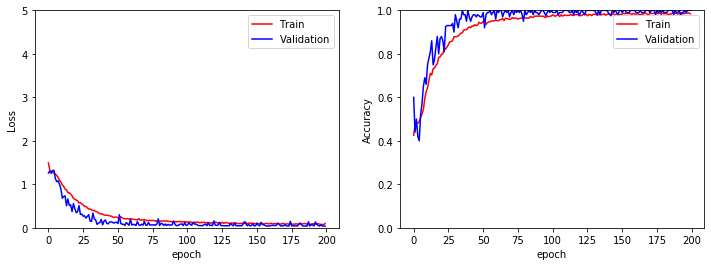

In [20]:
plot_results(res)

## Predicting images from external sources
## Independent Evaluation

In [21]:
#load images into dataset
images = []

for filepath in glob.glob('ind_eval/shape/*/*', recursive=True): 
    shape = filepath.split("\\")[-2]
    images.append((filepath, shape))

ie = pd.DataFrame(data=images, columns=['image_path', 'shape'])

In [22]:
#Pre process images
datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

ie_generator = datagen.flow_from_dataframe(
        dataframe=ie,
        directory='./',
        x_col="image_path",
        y_col="shape",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')


Found 25 validated image filenames belonging to 5 classes.


## Use model to predict on images, red indicates an incorrect prediction

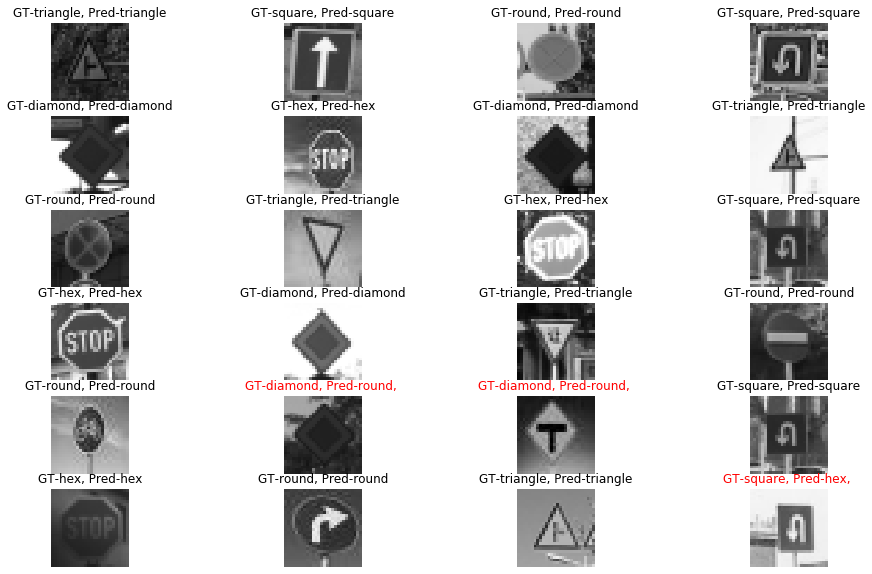

In [24]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,10))
batches = 0
incorrect = 0
for x,y in ie_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 25:
            plt.subplot(6,4,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            if d_inv[np.argmax(y[0])] != d_inv[np.argmax(y_hat[0])]:
                plt.title("GT-{}, Pred-{}, ".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])]), color = 'r')    
                incorrect = incorrect + 1
        else:
            break
        
        plt.axis('off')

In [25]:
print("Number of incorrect predictions: ", incorrect, "out of 25")

Number of incorrect predictions:  3 out of 25
